In [276]:
import numpy as np
import matplotlib.pyplot as plt
import bemcs

## Current Issues

- Dealing with rotation matrices in displacement and stress kernel calculations 
  - I have confused myself regarding the order in which rotation/inverse rotation matrices need to be applied
  - I need to check if we need to translate the observation coordinates relative to the patch center or not 
- While computing the linear operator/matrix for quadratic coefficients to boundary conditions ($L.x = b$), I realize that the $f$, $\frac{df}{dx}$ are calculated in terms of the the global horizontal coordinate system, not a local patch-centric coordinate system. This is great for the planar fault, but breaks everything for a non-planar fault.

In [ ]:

def get_designmatrix_3qn(elements):
    """ Compute design matrix for linear system to calculate quadratic coefficients from applied boundary conditions
        Currently only apply slip, slip gradient boundary conditions as well as
        continuity and 1-differentiability of slip at internal overlapping nodes"""
    designmatrix_slip = np.zeros((3*len(elements),3*len(elements)))
    designmatrix_slipgradient = np.zeros((3*len(elements),3*len(elements)))

    for i in range(len(elements)):
        slip_matrix = np.zeros((3,3))
        slipgradient_matrix = np.zeros((3,3))
        
        x_obs = np.array((elements[i]["x1"]-elements[i]["x_center"], 0., elements[i]["x2"]-elements[i]["x_center"]))

        slip_matrix = bemcs.slip_functions(x_obs, elements[i]["half_length"])        
        designmatrix_slip[3*i:3*i+3,3*i:3*i+3] = slip_matrix

        slipgradient_matrix = bemcs.slipgradient_functions(x_obs, elements[i]["half_length"])        
        designmatrix_slipgradient[3*i:3*i+3,3*i:3*i+3] = slipgradient_matrix

    return designmatrix_slip, designmatrix_slipgradient

def rotate_displacement_stress(displacement, stress, inverse_rotation_matrix):
    """ Rotate displacements stresses from local to global reference frame """
    displacement = np.matmul(displacement.T, inverse_rotation_matrix).T
    for i in range(0, stress.shape[1]):
        stress_tensor = np.array(
            [[stress[0, i], stress[2, i]], [stress[2, i], stress[1, i]]]
        )
        stress_tensor_global = (
            inverse_rotation_matrix.T @ stress_tensor @ inverse_rotation_matrix
        )
        stress[0, i] = stress_tensor_global[0, 0]
        stress[1, i] = stress_tensor_global[1, 1]
        stress[2, i] = stress_tensor_global[0, 1]
    return displacement, stress

def get_quadratic_displacement_stress_kernel(x_obs,y_obs,elements,mu,nu):
    """Each stress kernel is a matrix of dimensions 
        Kxx = Nobs x 3xNpatches 
        Kyy = Nobs x 3xNpatches
        Kxy = Nobs x 3xNpatches
        Each displacement kernel is a matrix of dimensions
        Gx = Nobs x 3xNpatches
        Gy = Nobs x 3xNpatches"""
    Kxx = np.zeros((len(x_obs),3*len(elements)))
    Kyy = np.zeros((len(x_obs),3*len(elements)))
    Kxy = np.zeros((len(x_obs),3*len(elements)))
    Gx = np.zeros((len(x_obs),3*len(elements)))
    Gy = np.zeros((len(x_obs),3*len(elements)))

    tensile_slip = [0.0, 0.0, 0.0]

    for i in range(len(elements)):
        # center observation locations
        x_trans = x_obs #- elements[i]["x_center"] 
        y_trans = y_obs #+ elements[i]["y_center"] 
        # rotate observations such that fault element is horizontal
        rotated_coordinates = elements[i]["rotation_matrix"]@np.vstack((x_trans.T,y_trans.T))
        x_rot = rotated_coordinates[0,:].T
        y_rot = rotated_coordinates[1,:].T

        # go through each of the 3 components for a given patch
        # component 1
        strike_slip = [1.0, 0.0, 0.0]        
        # Calculate displacements and stresses for current element
        displacement_local,stress_local = bemcs.displacements_stresses_quadratic_no_rotation(
            x_rot,y_rot,elements[i]["half_length"],mu,nu,strike_slip,tensile_slip,
            elements[i]["x_center"],elements[i]["y_center"])
        displacement_eval,stress_eval = rotate_displacement_stress(displacement_local,stress_local, elements[i]["inverse_rotation_matrix"])
        index = 3*i
        Kxx[:,index] = stress_eval[0,:]
        Kyy[:,index] = stress_eval[1,:]
        Kxy[:,index] = stress_eval[2,:]
        Gx[:,index] = displacement_eval[0,:]
        Gy[:,index] = displacement_eval[1,:]

        # component 2
        strike_slip = [0.0, 1.0, 0.0]        
        # Calculate displacements and stresses for current element
        displacement_local,stress_local = bemcs.displacements_stresses_quadratic_no_rotation(
            x_rot,y_rot,elements[i]["half_length"],mu,nu,strike_slip,tensile_slip,
            elements[i]["x_center"],elements[i]["y_center"])
        displacement_eval,stress_eval = rotate_displacement_stress(displacement_local,stress_local, elements[i]["inverse_rotation_matrix"])
        index = 3*i + 1
        Kxx[:,index] = stress_eval[0,:]
        Kyy[:,index] = stress_eval[1,:]
        Kxy[:,index] = stress_eval[2,:]
        Gx[:,index] = displacement_eval[0,:]
        Gy[:,index] = displacement_eval[1,:]

        # component 3
        strike_slip = [0.0, 0.0, 1.0]        
        # Calculate displacements and stresses for current element
        displacement_local,stress_local = bemcs.displacements_stresses_quadratic_no_rotation(
            x_rot,y_rot,elements[i]["half_length"],mu,nu,strike_slip,tensile_slip,
            elements[i]["x_center"],elements[i]["y_center"])
        displacement_eval,stress_eval = rotate_displacement_stress(displacement_local,stress_local, elements[i]["inverse_rotation_matrix"])
        index = 3*i + 2
        Kxx[:,index] = stress_eval[0,:]
        Kyy[:,index] = stress_eval[1,:]
        Kxy[:,index] = stress_eval[2,:]
        Gx[:,index] = displacement_eval[0,:]
        Gy[:,index] = displacement_eval[1,:]

    return Kxx, Kyy, Kxy, Gx, Gy

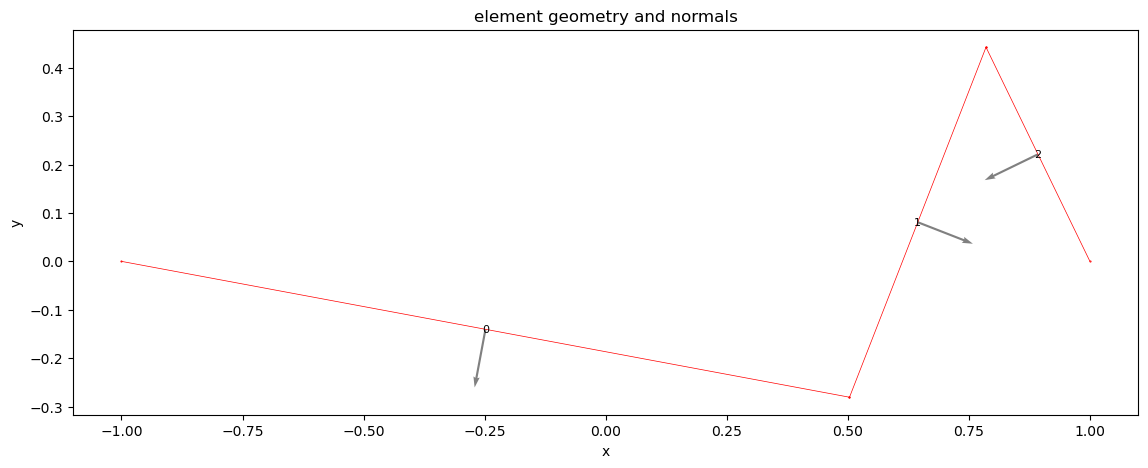

In [269]:
# use a non-uniform mesh
n_elements = 3
sorted_xlocs = np.sort(np.random.uniform(size=n_elements-1,low=-0.9,high=0.9))
sorted_ylocs = np.sort(np.random.uniform(size=n_elements-1,low=-0.8,high=0.8))

x1 = np.concatenate((np.array([-1.]), sorted_xlocs))
x2 = np.concatenate((sorted_xlocs,np.array([1.])))
y1 = np.concatenate((np.array([0.]), sorted_ylocs))
y2 = np.concatenate((sorted_ylocs,np.array([0.])))

# imposed slip at patch centers (make sure it is the same dimensions as x1)
slip_vector = np.random.uniform(size=n_elements)
# slip_vector = np.array((0,0.2,0.5,0.3,0.1))
# slip_vector = np.array((0.1,1.0,2.1,2.1,0.9,0.01))

elements = []
element = {}
for i in range(n_elements):
    element["x1"] = x1[i]
    element["y1"] = y1[i]
    element["x2"] = x2[i]
    element["y2"] = y2[i]
    elements.append(element.copy())
elements = bemcs.standardize_elements(elements)

# plot geometry of mesh
plt.figure(figsize=(15,5))
bemcs.plot_element_geometry(elements)

In [ ]:

# design matrices for slip and slip gradients at each 3qn
matrix_slip, matrix_slipgradient = get_designmatrix_3qn(elements)
matrix_system = np.zeros((len(elements)*3,len(elements)*3))

""" boundary conditions to solve for 3xNpatch unknown 3qn coefficients are as follows:
    (1) Npatch slip values at patch centers
    (2) Npatch-1 internal slip continuity at overlapping nodes
    (3) Npatch-1 internal slip gradient continuity at overlapping nodes
    (4) 2 slip gradients at the boundaries
"""

# Boundary conditions are ordered as patch1[n1,n2],patch1[n3]=patch2[n1],patch1[n3]grad=patch1[n1]grad,patch2[n2],....,patchN[n2,n3]
BCvector = np.zeros((len(elements)*3,1))
# slip gradients at the boundaries (we set them to 0 in this example)
BCvector[0] = 0
BCvector[-1] = 0

# slip imposed at central nodes of each patch
BCvector[1:-1:3] = slip_vector.reshape(-1,1)

# Linear operator for BCs as a matrix
# boundary nodes
matrix_system[0,:] = matrix_slipgradient[0,:]
matrix_system[-1,:] = matrix_slipgradient[-1,:]
# patch center nodes
matrix_system[1:-1:3,:] = matrix_slip[1:-1:3,:]
# overlapping interior nodes (apply slip continuity and smoothness)
matrix_system[2:-3:3,:] = matrix_slip[2:-3:3,:] - matrix_slip[3:-2:3,:]
matrix_system[3:-2:3,:] = matrix_slipgradient[2:-3:3,:] - matrix_slipgradient[3:-2:3,:]

# compute quadratic node coefficients
quadratic_coefs = np.linalg.inv(matrix_system) @ BCvector
print(quadratic_coefs.reshape(n_elements,3))


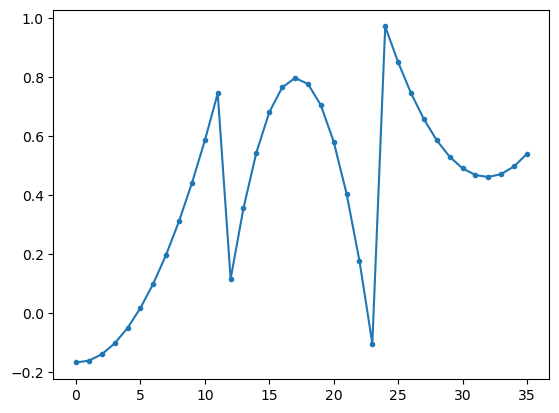

In [275]:
# compute slip over each patch (evaluate distance along a patch with n_pts nodes)
n_pts = 12
xnodes = np.zeros((n_elements*n_pts,1)) + elements[0]["x1"]
# ynodes = np.zeros_like(xnodes)

# get slip along the fault from quadratic coefficients
slip_fullfault = np.zeros((n_elements*n_pts,1))
for i in range(len(elements)):
    coef_index = list(range(3*i, 3*i+3, 1))
    node_index = list(range(n_pts*i, n_pts*(i+1), 1))
    # print(node_index)
    # print(xnodes[node_index[0]])

    x_vec = np.linspace(-elements[i]["half_length"],elements[i]["half_length"],n_pts)
    L = elements[0]["length"]
    for count in range(i+1):
        L += elements[count]["length"]
        # print(count)
    # print(L)
    xnodes[node_index,0] = x_vec + elements[i]["half_length"] + L
    slip_patch,_ = bemcs.get_slip_slipgradient(x_vec, elements[i]["half_length"], quadratic_coefs[coef_index])
    slip_fullfault[node_index] = slip_patch

plt.figure()
# plt.stem(0.5*(x1+x2),slip_vector,'ko-')
plt.plot(slip_fullfault,'.-')
plt.show()



In [272]:
# compute displacement and stress kernels
# Elastic parameters
mu = 1
nu = 0.25
n_obs = 100
width = 2
x_obs = np.linspace(-width, width, n_obs)
y_obs = np.linspace(-width/2, width/2, n_obs)

x_obs, y_obs = np.meshgrid(x_obs, y_obs)
x_obs = x_obs.flatten()
y_obs = y_obs.flatten()
Kxx,Kyy,Kxy,Gx,Gy = get_quadratic_displacement_stress_kernel(x_obs,y_obs,elements,mu,nu)


In [273]:
# np.vstack((x_obs.T,y_obs.T))
# elements[i]["rotation_matrix"]

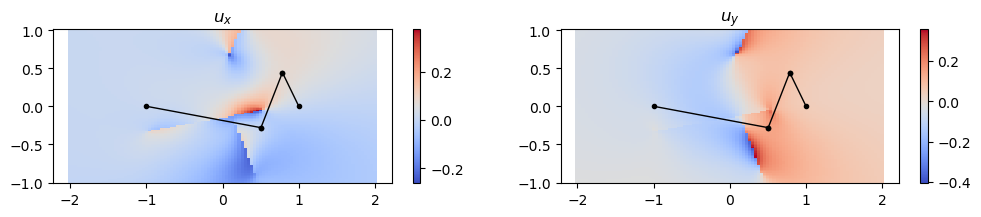

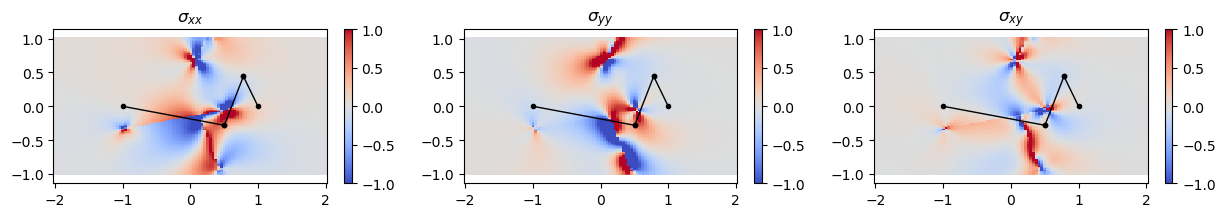

In [274]:
# plot displacements and stresses

# displacements
plt.figure(figsize=(12,2))
plt.subplot(1, 2, 1)
toplot = Gx @ quadratic_coefs
plt.pcolor(x_obs.reshape(n_obs, n_obs), y_obs.reshape(n_obs, n_obs), toplot.reshape(n_obs, n_obs),cmap='coolwarm')
for element in elements:
    plt.plot([element["x1"], element["x2"]],[element["y1"], element["y2"]],".-k",linewidth=1.0)
# plt.clim(-0.5,0.5)
plt.colorbar()
plt.axis("equal")
plt.title("$u_x$")

plt.subplot(1, 2, 2)
toplot = Gy @ quadratic_coefs
plt.pcolor(x_obs.reshape(n_obs, n_obs), y_obs.reshape(n_obs, n_obs), toplot.reshape(n_obs, n_obs),cmap='coolwarm')
for element in elements:
    plt.plot([element["x1"], element["x2"]],[element["y1"], element["y2"]],".-k",linewidth=1.0)
plt.colorbar()
# plt.clim(-0.2,0.2)
plt.title("$u_y$")
plt.axis("equal")
plt.show()

# plot stresses
plt.figure(figsize=(15, 2))
plt.subplot(1, 3, 1)
toplot = Kxx @ quadratic_coefs
plt.pcolor(x_obs.reshape(n_obs, n_obs), y_obs.reshape(n_obs, n_obs), toplot.reshape(n_obs, n_obs),cmap='coolwarm')
for element in elements:
    plt.plot([element["x1"], element["x2"]],[element["y1"], element["y2"]],".-k",linewidth=1.0)
plt.colorbar()
plt.clim(-1,1)
plt.axis("equal")
plt.title("$\sigma_{xx}$")

plt.subplot(1, 3, 2)
toplot = Kyy @ quadratic_coefs
plt.pcolor(x_obs.reshape(n_obs, n_obs), y_obs.reshape(n_obs, n_obs), toplot.reshape(n_obs, n_obs),cmap='coolwarm')
for element in elements:
    plt.plot([element["x1"], element["x2"]],[element["y1"], element["y2"]],".-k",linewidth=1.0)
plt.colorbar()
plt.clim(-1,1)
plt.axis("equal")
plt.title("$\sigma_{yy}$")

plt.subplot(1, 3, 3)
toplot = Kxy @ quadratic_coefs
plt.pcolor(x_obs.reshape(n_obs, n_obs), y_obs.reshape(n_obs, n_obs), toplot.reshape(n_obs, n_obs),cmap='coolwarm')
for element in elements:
    plt.plot([element["x1"], element["x2"]],[element["y1"], element["y2"]],".-k",linewidth=1.0)
plt.colorbar()
plt.clim(-1,1)
plt.axis("equal")
plt.title("$\sigma_{xy}$")
plt.show()